# Hamilton House Price Prediction: Spatial vs. Non-Spatial Regression Methods

### 1. Problem Definition

### 2. Data 

### 3. Evaluation

### 4. Features

### 5. Preparing the Tools

In [5]:
# Importing EDA and Plotting Libraries
import pandas as pd
from pandas import set_option
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
# plots should appear in the notebook
%matplotlib inline 
import seaborn as sns

# Importing Spatial Analysis Libraries
import geopandas as gpd

# Regression Models for Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesRegressor

# Regression Model Tools
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn.pipeline import Pipeline

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

### 6. Load Data

In [6]:
# Hamilton House Pricing & Boundary Data
url = "https://raw.githubusercontent.com/gisUTM/GGR376/master/Lab_1/houseValues.geojson"
house_prices_boundaries = gpd.read_file(url)
house_prices_boundaries.head(5)

,CTUID,houseValue,geometry
0,5370001.09,420276.0,"POLYGON ((-79.85586 43.18790, -79.85592 43.187..."
1,5370120.02,601551.0,"POLYGON ((-79.94562 43.16920, -79.94637 43.167..."
2,5370140.03,525073.0,"POLYGON ((-79.89977 43.33088, -79.89977 43.330..."
3,5370140.04,524777.0,"POLYGON ((-79.89286 43.32909, -79.89226 43.328..."
4,5370001.08,400617.0,"POLYGON ((-79.85362 43.19320, -79.85380 43.192..."


In [7]:
# Hamilton Housing Features Data
house_attributes = pd.read_csv("hamilton_census_data.csv")
house_attributes.head(5)

,CTUID,priv_dwellings_by_bedroom,priv_dwellings_by_rooms,major_repairs,monthly_housing_costs,percent_mortgage,income_after_tax,house_by_person_per_room,avg_house_size,population,land_area
0,5370000.00,293345,293345,18370,1294,60.6,66100,293345,2.5,747545,1371.89
1,5370001.01,760,760,35,1269,57.9,69530,760,2.9,2193,5.52
2,5370001.02,1760,1760,70,1493,70.2,72590,1755,3.0,5302,1.29
3,5370001.04,1900,1895,50,1367,59.7,83257,1895,3.3,6305,1.70
4,5370001.05,1605,1610,45,1569,65.3,75136,1605,3.2,5344,1.55


In [8]:
# Merge Features Data & House Pricing/Boundary Data 
df = house_prices_boundaries.merge(house_attributes, on = "CTUID")
df.head(5)

,CTUID,houseValue,geometry,priv_dwellings_by_bedroom,priv_dwellings_by_rooms,major_repairs,monthly_housing_costs,percent_mortgage,income_after_tax,house_by_person_per_room,avg_house_size,population,land_area
0,5370001.09,420276.0,"POLYGON ((-79.85586 43.18790, -79.85592 43.187...",1390,1390,25,1612,72.3,78976,1395,3.3,4566,1.97
1,5370120.02,601551.0,"POLYGON ((-79.94562 43.16920, -79.94637 43.167...",690,685,75,1460,55.5,87211,685,3.0,7821,27.69
2,5370140.03,525073.0,"POLYGON ((-79.89977 43.33088, -79.89977 43.330...",2505,2505,50,1883,78.3,98624,2505,2.8,5879,2.37
3,5370140.04,524777.0,"POLYGON ((-79.89286 43.32909, -79.89226 43.328...",1320,1315,25,1705,63.5,94948,1320,3.0,8605,10.22
4,5370001.08,400617.0,"POLYGON ((-79.85362 43.19320, -79.85380 43.192...",2050,2050,35,1513,66.7,80576,2055,3.2,6556,1.64


### 7. Exploratory Data Analysis (EDA)
EDA Template that will be followed for this problem:
1. What question(s) are you trying to solve (or prove wrong)?
2. What kind of data do you have and what are the different types of data present?
3. What's missing from the data and how do you deal with it?
4. Where are the outliers and are they something to be concerned about?
5. How can you add, change or remove features to get more out of your data?

#### 7.1 Data Description

In [9]:
# Top 10 rows of dataframe
df.head(10)

,CTUID,houseValue,geometry,priv_dwellings_by_bedroom,priv_dwellings_by_rooms,major_repairs,monthly_housing_costs,percent_mortgage,income_after_tax,house_by_person_per_room,avg_house_size,population,land_area
0,5370001.09,420276.0,"POLYGON ((-79.85586 43.18790, -79.85592 43.187...",1390,1390,25,1612,72.3,78976,1395,3.3,4566,1.97
1,5370120.02,601551.0,"POLYGON ((-79.94562 43.16920, -79.94637 43.167...",690,685,75,1460,55.5,87211,685,3.0,7821,27.69
2,5370140.03,525073.0,"POLYGON ((-79.89977 43.33088, -79.89977 43.330...",2505,2505,50,1883,78.3,98624,2505,2.8,5879,2.37
3,5370140.04,524777.0,"POLYGON ((-79.89286 43.32909, -79.89226 43.328...",1320,1315,25,1705,63.5,94948,1320,3.0,8605,10.22
4,5370001.08,400617.0,"POLYGON ((-79.85362 43.19320, -79.85380 43.192...",2050,2050,35,1513,66.7,80576,2055,3.2,6556,1.64
5,5370223.09,674299.0,"POLYGON ((-79.78562 43.39827, -79.78568 43.398...",2685,2690,35,2052,83.0,109391,2685,3.0,4577,2.49
6,5370223.10,598768.0,"POLYGON ((-79.79016 43.39399, -79.79036 43.393...",1580,1580,10,1834,78.6,96293,1580,2.6,3157,0.98
7,5370223.12,449485.0,"POLYGON ((-79.78571 43.36864, -79.78664 43.367...",3585,3590,135,1473,69.3,70326,3585,3.2,3954,1.44
8,5370055.00,240132.0,"POLYGON ((-79.80015 43.23902, -79.80054 43.238...",1275,1280,155,1054,70.0,53555,1275,2.2,3120,0.50
9,5370069.00,179211.0,"POLYGON ((-79.78823 43.27508, -79.78661 43.273...",400,400,30,974,90.9,46848,395,2.2,1855,2.37


In [10]:
# Shape of dataframe
print(df.shape)

(187, 13)


This dataset contains 187 observations/census districts in Hamilton, ON (the rows), and each observation/census district in Hamilton is accompanied with 13 housing attributes/features (columns) about them that are related to house pricing. 

#### 7.2 Descriptive Statistics

In [11]:
# Data types
df.dtypes

CTUID                         float64
houseValue                    float64
geometry                     geometry
priv_dwellings_by_bedroom       int64
priv_dwellings_by_rooms         int64
major_repairs                   int64
monthly_housing_costs           int64
percent_mortgage              float64
income_after_tax                int64
house_by_person_per_room        int64
avg_house_size                float64
population                      int64
land_area                     float64
dtype: object

In [12]:
# Number of unique values in each column for the features data
dict = {}
for i in list(house_attributes.columns):
    dict[i] = house_attributes[i].value_counts().shape[0]

pd.DataFrame(dict, index = ["# of Unique Values:"]).transpose()

,# of Unique Values:
CTUID,188
priv_dwellings_by_bedroom,164
priv_dwellings_by_rooms,155
major_repairs,52
monthly_housing_costs,167
percent_mortgage,155
income_after_tax,182
house_by_person_per_room,159
avg_house_size,21
population,184


After inspecting unique values, it is safe to conclude that we do not have any repeating census districts in our data.

In [13]:
# Seperating the columns into categorical, continous and spatial features
categorical_cols = ["CTUID"]
continuous_cols = ["priv_dwellings_by_bedroom", "priv_dwellings_by_rooms", "major_repairs", "monthly_housing_costs", "percent_mortgage", "income_after_tax", "house_by_person_per_room", "avg_house_size", "population", "land_area"]
spatial_cols = ["geometry"]
target_col = ["houseValue"]

In [11]:
# Summary Statistics for features
df[continuous_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
priv_dwellings_by_bedroom,187.0,1551.096257,675.297029,45.00,1085.000,1410.0,1970.000,3585.00
priv_dwellings_by_rooms,187.0,1551.149733,675.453364,45.00,1085.000,1415.0,1970.000,3590.00
major_repairs,187.0,97.165775,69.089620,0.00,50.000,75.0,135.000,395.00
monthly_housing_costs,187.0,1241.331551,280.319992,686.00,1025.500,1201.0,1440.500,2263.00
percent_mortgage,187.0,59.420321,10.941104,0.00,52.000,59.2,67.700,90.90
income_after_tax,187.0,68376.438503,22060.550335,20320.00,50533.500,67157.0,84317.000,128213.00
house_by_person_per_room,187.0,1551.096257,675.429972,45.00,1085.000,1415.0,1970.000,3585.00
avg_house_size,187.0,2.503209,0.408894,1.30,2.200,2.5,2.800,3.40
population,187.0,3862.160428,1871.094716,0.00,2612.000,3549.0,4622.000,10637.00
land_area,187.0,7.213636,19.724983,0.32,0.855,1.4,2.525,137.49


In [12]:
# Summary Statistics for target (House Prices)
df[target_col].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
houseValue,187.0,428997.080214,153776.273172,160515.0,320617.5,400757.0,521803.5,946729.0


In [13]:
# Correlation between features and target
set_option('precision', 2)
print(df.corr(method = "pearson"))

                              CTUID  houseValue  priv_dwellings_by_bedroom  \
CTUID                      1.00e+00        0.63                       0.18   
houseValue                 6.31e-01        1.00                       0.06   
priv_dwellings_by_bedroom  1.81e-01        0.06                       1.00   
priv_dwellings_by_rooms    1.81e-01        0.06                       1.00   
major_repairs             -2.17e-01       -0.48                       0.42   
monthly_housing_costs      4.12e-01        0.55                       0.29   
percent_mortgage          -9.58e-03       -0.27                       0.16   
income_after_tax           4.93e-01        0.80                       0.06   
house_by_person_per_room   1.81e-01        0.06                       1.00   
avg_house_size             1.52e-01        0.23                       0.09   
population                 1.52e-01        0.23                       0.15   
land_area                  2.10e-01        0.27                 

Interestingly, some attributes have a strong correlation (>0.70 or <-0.70) and some attributes have a 1.0 correlation.
* priv_dwellings_by_bedroom and priv_dwellings_by_rooms with 1.00
* priv_dwellings_by_bedroom and house_by_person_per_room with 1.00
* priv_wellings_by_rooms and house_by_person_per_room with 1.00
* The remaining variables are uncorrelated in negative and postive directions.

#### 7.3 Handling Missing Values & Duplicates

In [14]:
# Number of missing values
df.isnull().sum()

CTUID                        0
houseValue                   0
geometry                     0
priv_dwellings_by_bedroom    0
priv_dwellings_by_rooms      0
major_repairs                0
monthly_housing_costs        0
percent_mortgage             0
income_after_tax             0
house_by_person_per_room     0
avg_house_size               0
population                   0
land_area                    0
dtype: int64

There are **no missing values** in this dataset!

In [15]:
# Number of duplicates
duplicates_number = df.duplicated().sum()
print("Number of duplicated rows is: ", duplicates_number)

Number of duplicated rows is:  0


There are **no duplicate values** in this dataset!

#### 7.4 Data Visualizations
  ##### 7.4.1 Univariate Data Visualizations

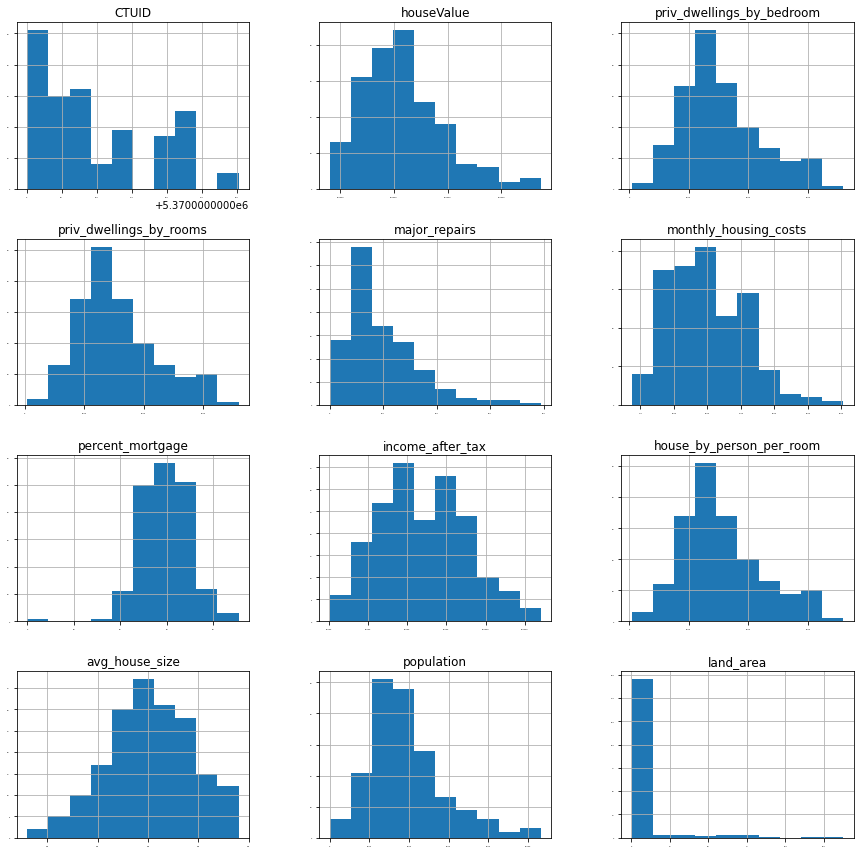

In [16]:
# Histograms
histograms = df.hist(sharex = False, sharey = False, xlabelsize = 2, ylabelsize = 2, figsize = (15, 15));

Most of our features appear to be uniform with some level of skew, specifically the `land_area` and `major_repairs` appear to skewed. The distribution of the `CTUID` feature does not matter as this is actually a ordinal feature.

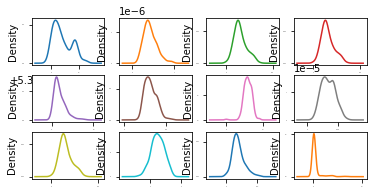

In [17]:
# Density Plots
df.plot(kind = "density", subplots = True, layout = (4, 4), sharex = False, legend = False, fontsize = 1);

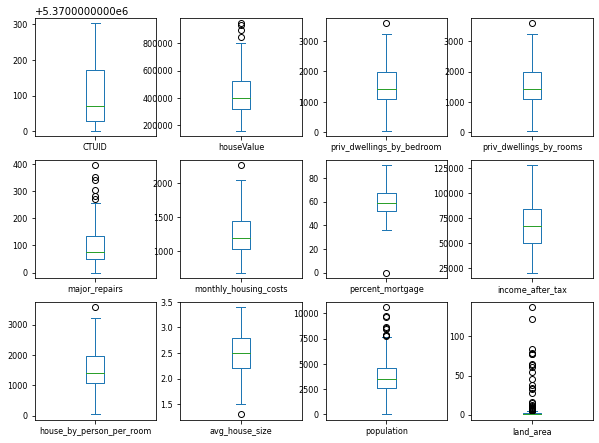

In [18]:
# Box and Whisker Plots
df.plot(kind = "box", subplots = True, layout = (4, 4), sharex = False, sharey = False, fontsize = 8, figsize = (10, 10));

 ##### 7.4.2 Multivariate Data Visualizations

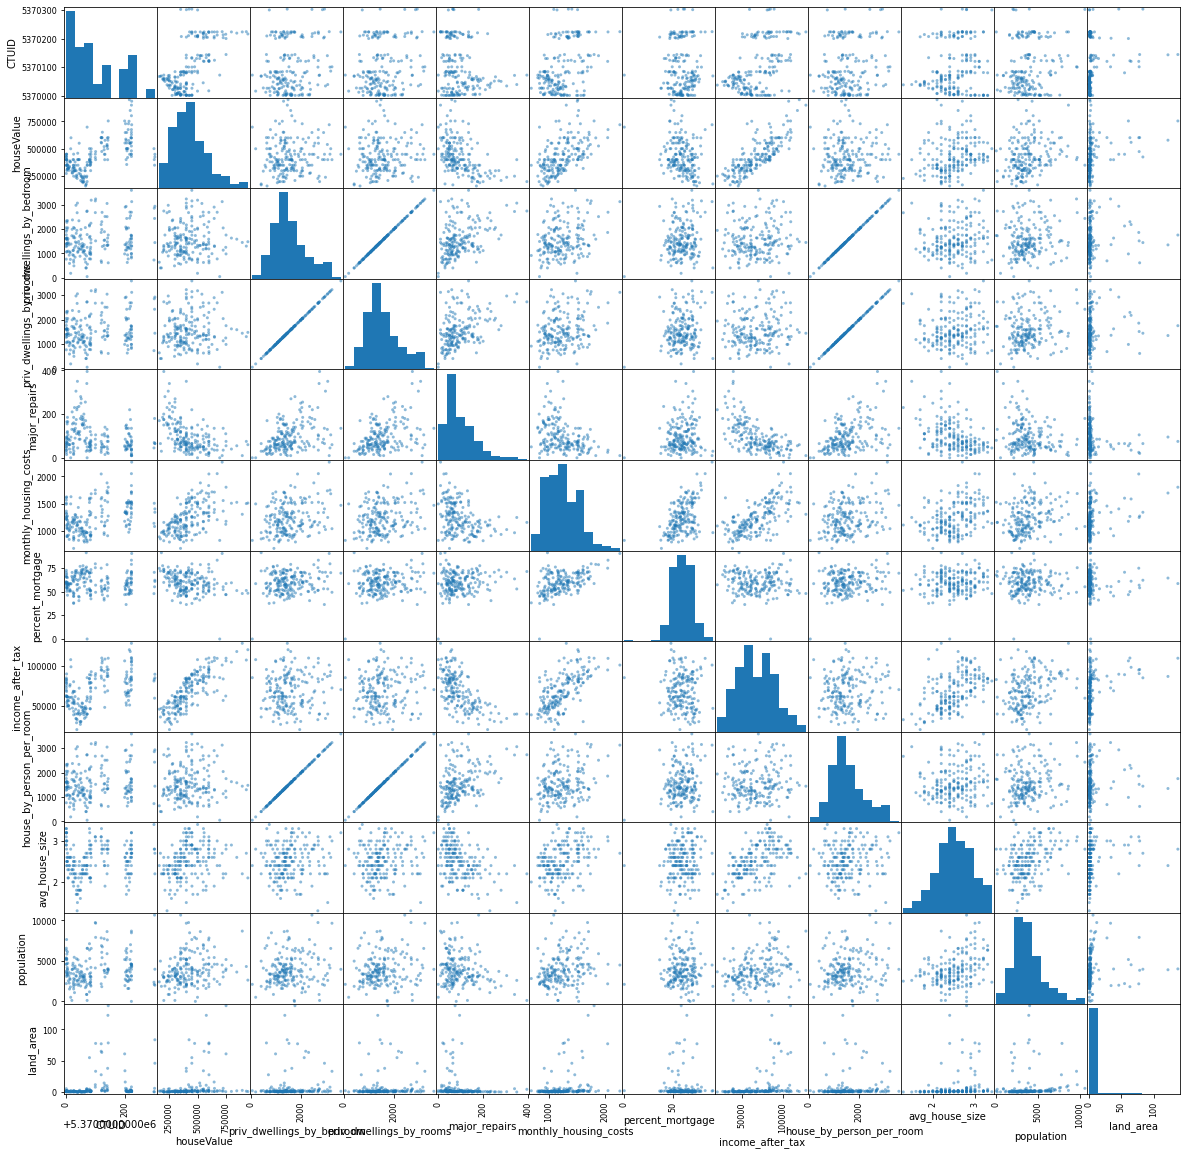

In [19]:
# Scatter plot matrix
scatter_matrix(df, figsize = (20, 20));

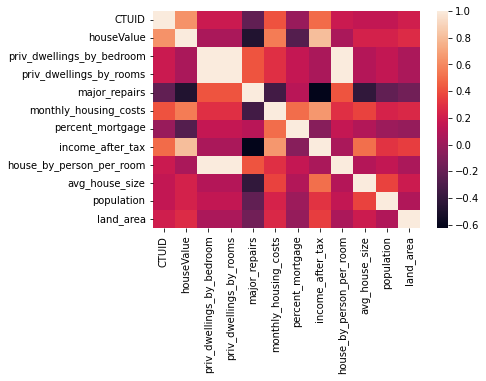

In [20]:
# Correlation Matrix
corrMatrix = df.corr()
sns.heatmap(corrMatrix);

The correlation matrix confirms that features `priv_dwellings_by_bedroom`, `priv_dwellings_byrooms` and `house_by_person_per_room` are postively correlated with a 1.0 correlation coefficient. Two of these features will be removed and only one of them will be kept for analysis. 

##### 7.4.3 Chloropleth Maps

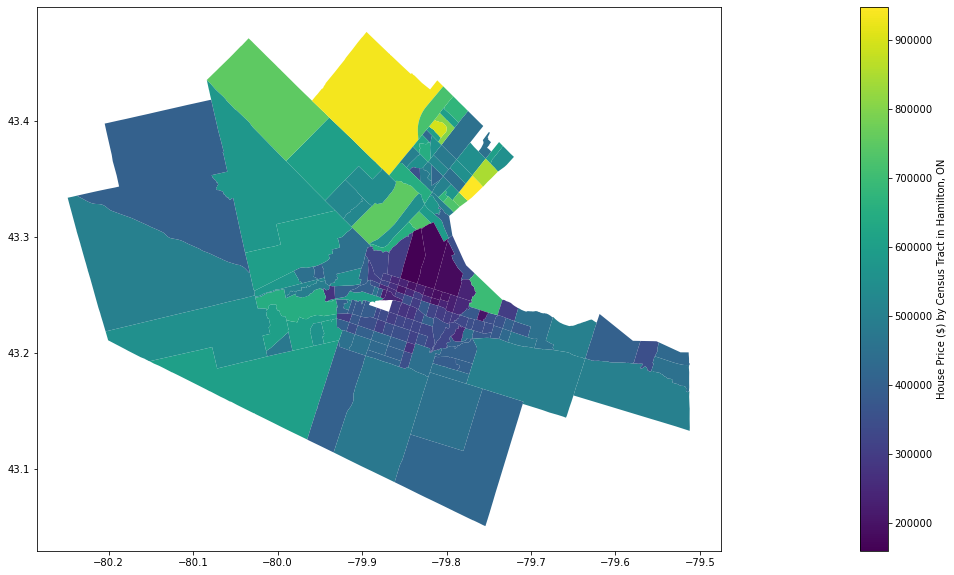

In [14]:
# Chloropleth Map of house value by census tract
df.plot(column = "houseValue",
           legend = True,
           figsize = [50, 10],
           legend_kwds = {'label': "House Price ($) by Census Tract in Hamilton, ON"});

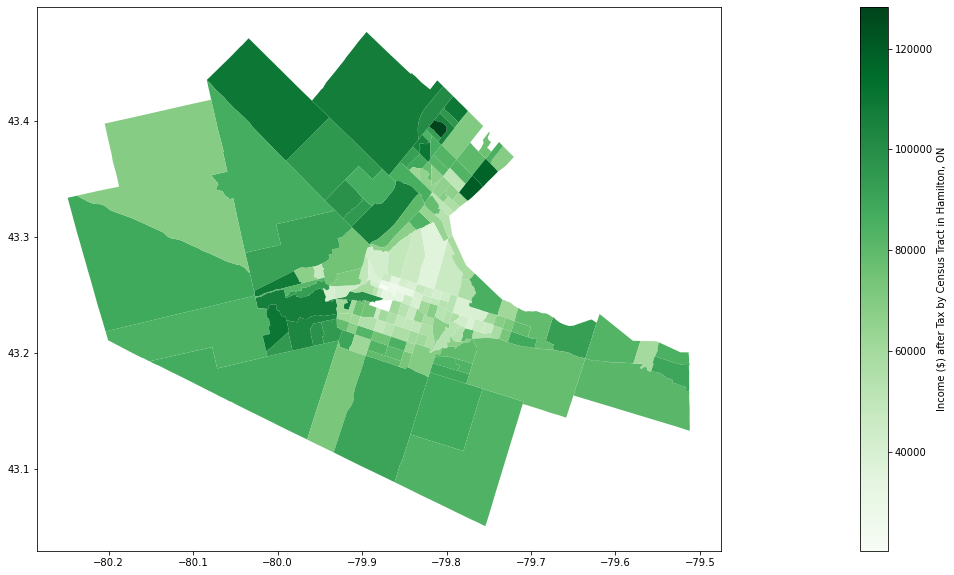

In [23]:
# Chloropleth Map of income per household by census tract
df.plot(column = "income_after_tax",
           legend = True,
           figsize = [50, 10],
           legend_kwds = {'label': "Income ($) after Tax by Census Tract in Hamilton, ON"},
           cmap = "Greens");